# Scorecard data - Further narrow feature set


This file contains work to further narrow the feature set -- got from 200 columns down to about 30 that
I played with for contstructing the linear model.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

## Read in the first pass scorecard data

In [2]:
filedir = "../data/"
filename =  filedir +  "MERGED2016_17_subset.pck" 
dataframe = pd.read_pickle(filename) 

In [3]:
dataframe.shape

(1819, 203)

## Read in the data dictionary and define a quick reference function I can use from the console

In [4]:
datad = pd.read_excel("../data/CollegeScorecardDataDictionary.xlsx", sheet_name="data_dictionary")
datad.columns = datad.columns.str.replace(" ", "_").str.replace("-", "_").str.lower()

In [5]:
# A way to quickly look up a column meaning while working on this notebook
def reference(column):
    if type(column) == str:
        ref = datad.loc[datad.variable_name == column, :]
        ref = ref.iloc[0]
        print(ref.variable_name)
        print(ref.dev_category, ref.api_data_type, ref.source)
        print(ref.name_of_data_element)
        print(ref.notes)
    else: 
        # assume it's a list or series
        for c in column:
            reference(c)
            print("")
        

# Select target column

I'm not sure what it is, but I know it came from the NSLDS (National Student Loan Data System).

Which columns in my filtered data sets came from the NSLDS? 

In [6]:
# find the columns that come from NSLDS and are in my data subset
nslds = datad.query("source == 'NSLDS'")
nslds_vars = nslds.variable_name.dropna()

In [7]:
cols = dataframe.columns

In [8]:
nslds_cols = cols[ cols.isin(nslds_vars) ]

In [9]:
nslds_cols

Index(['INC_PCT_LO', 'DEP_STAT_PCT_IND', 'DEP_INC_PCT_LO', 'IND_INC_PCT_LO',
       'PAR_ED_PCT_1STGEN', 'INC_PCT_M1', 'INC_PCT_M2', 'INC_PCT_H1',
       'INC_PCT_H2', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1',
       'DEP_INC_PCT_H2', 'IND_INC_PCT_M1', 'IND_INC_PCT_M2', 'IND_INC_PCT_H1',
       'IND_INC_PCT_H2', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_PS',
       'APPL_SCH_PCT_GE2', 'APPL_SCH_PCT_GE3', 'APPL_SCH_PCT_GE4',
       'APPL_SCH_PCT_GE5', 'DEP_INC_AVG', 'IND_INC_AVG', 'DEBT_MDN',
       'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN', 'LO_INC_DEBT_MDN', 'MD_INC_DEBT_MDN',
       'HI_INC_DEBT_MDN', 'DEP_DEBT_MDN', 'IND_DEBT_MDN', 'PELL_DEBT_MDN',
       'NOPELL_DEBT_MDN', 'FEMALE_DEBT_MDN', 'MALE_DEBT_MDN',
       'FIRSTGEN_DEBT_MDN', 'NOTFIRSTGEN_DEBT_MDN', 'DEBT_N', 'GRAD_DEBT_N',
       'WDRAW_DEBT_N', 'LO_INC_DEBT_N', 'MD_INC_DEBT_N', 'HI_INC_DEBT_N',
       'DEP_DEBT_N', 'IND_DEBT_N', 'PELL_DEBT_N', 'NOPELL_DEBT_N',
       'FEMALE_DEBT_N', 'MALE_DEBT_N', 'FIRSTGEN_DEB

In [10]:
reference("LOAN_EVER")

LOAN_EVER
aid float NSLDS
Share of students who received a federal loan while in school
Data element describes the earnings cohort (without exclusions for military and in-school deferments in the measurement year)


In [11]:
reference("DEBT_MDN")

DEBT_MDN
aid float NSLDS
The median original amount of the loan principal upon entering repayment
nan


In [12]:
reference("GRAD_DEBT_MDN")

GRAD_DEBT_MDN
aid float NSLDS
The median debt for students who have completed
nan


In [14]:
cols = ['LOAN_EVER', 'DEBT_MDN', 'GRAD_DEBT_MDN']
print(dataframe.loc[:,cols].count())

LOAN_EVER        1634
DEBT_MDN         1711
GRAD_DEBT_MDN    1679
dtype: int64


I have a few more rows for ```DEBT_MDN``` than ```GRAD_DEBT_MDN```, but I think 
```GRAD_DEBT_MDN``` is closer to my original problem statement.

In [16]:
# Drop rows where the GRAD_DEBT_MDN is not known
print(dataframe.shape)
dataframe.dropna(subset=['GRAD_DEBT_MDN'], inplace=True)
print(dataframe.shape)

(1819, 203)
(1679, 203)


## Choosing features/predictors 


In [17]:
# I start assuming all the columns will be predictors and this function
# pops columns off the list as I decide not to use them
def pop_predictor(col):
    if type(col) == str:
        try:
            predictors.remove(col)
        except ValueError:
            pass
    else:
        for c in col:
            pop_predictor(c)
        return


In [18]:
# Initial set of predictors -- based on what wasn't dropped
# in the first pass through the data

In [20]:
predictors = dataframe.columns

In [21]:
predictors

Index(['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP',
       'ACCREDAGENCY', 'INSTURL', 'NPCURL',
       ...
       'GRADS', 'ACCREDCODE', 'RET_FT4_POOLED', 'RET_PT4_POOLED',
       'RET_FT_DEN4_POOLED', 'RET_PT_DEN4_POOLED', 'POOLYRSRET_FT',
       'POOLYRSRET_PT', 'RET_FT4_POOLED_SUPP', 'RET_PT4_POOLED_SUPP'],
      dtype='object', length=203)

In [22]:
# GRAD_DEBT_MDN is my target, and the other DEBT fields are really not fair game
# e.g. debt incurred by various subsets of students would just be collinear

In [23]:
predictors = [ p for p in predictors if p.find("DEBT") == -1 ]

In [26]:
# dropping all other debt columns besides my target variable gets me down to 166 columns
len(predictors)

166

In [27]:
reference('COSTT4_A')


COSTT4_A
cost integer IPEDS
Average cost of attendance (academic year institutions)
The average annual total cost of attendance, including tuition and fees, books and supplies, and living expenses for all full-time, first-time, degree/certificate-seeking undergraduates who receive Title IV aid. It is calculated from values in the IPEDS Institutional Characteristics and Student Financial Aid components. Separate metrics are calculated for academic-year institutions and program-year institutions. For academic-year institutions, average cost of attendance represents an average of all programs and includes only full-time, first-time, degree/certificate-seeking undergraduates who first enrolled in the fall term. For non-academic-year institutions (program or continuous enrollment), average cost of attendance represents the program with the largest enrollment at the institution, and it includes full-time, first-time, degree/certificate-seeking undergraduates who first enrolled at any time du

In [29]:
costvars = ['COSTT4_A' ]
costvars += [ p for p in predictors if p.find("_PUB") != - 1]
costvars += [ p for p in predictors if p.find("_PRIV") != - 1]
dataframe[costvars].count()

COSTT4_A          1604
NPT4_PUB           563
NPT41_PUB          562
NPT42_PUB          562
NPT43_PUB          560
NPT44_PUB          557
NPT45_PUB          539
NPT4_048_PUB       563
NPT4_3075_PUB      562
NPT4_75UP_PUB      557
NUM4_PUB           563
NUM41_PUB          563
NUM42_PUB          563
NUM43_PUB          563
NUM44_PUB          563
NUM45_PUB          563
NPT4_PRIV         1041
NPT41_PRIV        1036
NPT42_PRIV        1026
NPT43_PRIV        1021
NPT44_PRIV         987
NPT45_PRIV         966
NPT4_048_PRIV     1040
NPT4_3075_PRIV    1031
NPT4_75UP_PRIV     995
NUM4_PRIV         1041
NUM41_PRIV        1041
NUM42_PRIV        1041
NUM43_PRIV        1041
NUM44_PRIV        1041
NUM45_PRIV        1041
dtype: int64

In [30]:
# I'm going to keep COSTT4_A which is calculated for both public and private universities and has
# the most observations of the cost columns

In [31]:
predictors = [ p for p in predictors if p.find("_PUB") == -1 ]
predictors = [ p for p in predictors if p.find("_PRIV") == -1 ]

In [32]:
# too many testing columns -- let's filter down a bit
test_cols = [ p for p in predictors if p.find("SAT") == 0 or p.find("ACT") == 0]
test_cols

['SATVR25',
 'SATVR75',
 'SATMT25',
 'SATMT75',
 'SATVRMID',
 'SATMTMID',
 'ACTCM25',
 'ACTCM75',
 'ACTEN25',
 'ACTEN75',
 'ACTMT25',
 'ACTMT75',
 'ACTCMMID',
 'ACTENMID',
 'ACTMTMID',
 'SAT_AVG',
 'SAT_AVG_ALL']

In [33]:
dataframe.loc[:, test_cols].count()

SATVR25        1166
SATVR75        1166
SATMT25        1168
SATMT75        1168
SATVRMID       1166
SATMTMID       1168
ACTCM25        1208
ACTCM75        1208
ACTEN25        1118
ACTEN75        1118
ACTMT25        1119
ACTMT75        1119
ACTCMMID       1208
ACTENMID       1118
ACTMTMID       1119
SAT_AVG        1229
SAT_AVG_ALL    1252
dtype: int64

In [34]:
reference(['SAT_AVG', 'SAT_AVG_ALL'])

SAT_AVG
admissions float IPEDS
Average SAT equivalent score of students admitted
Shown/used on consumer website.

SAT_AVG_ALL
admissions float IPEDS
Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID
Shown/used on consumer website.



In [35]:
# All of the testing cols are hightly correlated with each other and some further
# refinement is needed. For now, keeping the observations with the most rows
test_cols.remove('SAT_AVG')
test_cols.remove('SAT_AVG_ALL')
test_cols.remove('ACTCMMID')
pop_predictor(test_cols)

In [36]:
len(predictors)

122

In [49]:
# We still have a lot of labels and directory info which we cannot use as predictors
labels = ['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'ST_FIPS', 'REGION', 'ALIAS', 'INSTURL', 'NPCURL',
         'LATITUDE', 'LONGITUDE']

# we still need to remember to write these out for joining with collegedata.com data later
save_labels = ['INSTNM', 'CITY', 'STABBR'] 

pop_predictor(labels)

In [43]:
# we have a bunch of demographics on the earnings cohort
# which doesn't really fit my problem statement since I'm 
# not looking at earnings after graduation
earnings_related = (datad.variable_name.isin(predictors)) & (datad.notes.dropna().str.find("earnings cohort") != -1)
earnings_vars = datad.loc[earnings_related, 'variable_name']
earnings_vars

Series([], Name: variable_name, dtype: object)

In [44]:
pop_predictor(earnings_vars)

In [45]:
# we have a bunch of information on income levels
# which is also overkill as we cannot match a specific
# income level to a specific loan amount if the target
# variable is just the median loan amount
earnings_related = (datad.variable_name.isin(predictors)) & (datad.name_of_data_element.dropna().str.find("income") != -1)
earnings_vars = datad.loc[earnings_related, 'variable_name']
earnings_vars

1649        INC_PCT_LO
1651    IND_INC_PCT_LO
1652    DEP_INC_PCT_LO
1654        INC_PCT_M1
1655        INC_PCT_M2
1656        INC_PCT_H1
1657        INC_PCT_H2
1658    DEP_INC_PCT_M1
1659    DEP_INC_PCT_M2
1660    DEP_INC_PCT_H1
1661    DEP_INC_PCT_H2
1662    IND_INC_PCT_M1
1663    IND_INC_PCT_M2
1664    IND_INC_PCT_H1
1665    IND_INC_PCT_H2
1673       DEP_INC_AVG
1674       IND_INC_AVG
Name: variable_name, dtype: object

In [46]:
pop_predictor(earnings_vars)

In [47]:
# this column is all ones -- drop it
pop_predictor('ICLEVEL')  

In [50]:
# More stuff to drop: 
# ACCRED -- columns related accreditation
# PAR_ED_ -- columnns related to students' parents' level of education
# APPL_SCH_ -- number of schools applied to
# RET_ -- student retention rate
# POOLYRSRET_ -- more retention


In [82]:
drop_these = [ "ACCRED", "PAR_ED_", "APPL_SCH_", "RET_", "POOLYRSRET"]
for drop in drop_these:
    drop_cols = [ p for p in predictors if p.find(drop) == 0 ]
    pop_predictor(drop_cols)
    
# more to drop 
drop_these = [ 'HCM2', 'MAIN', 'NUMBRANCH',  'DEP_STAT_PCT_IND', # cash monitoring system, main/branch campus, dependency status
 'UGDS_MEN', 'UGDS_WOMEN','MENONLY','WOMENONLY', 'T4APPROVALDATE', 'D_PCTPELL_PCTFLOAN', 'UGNONDS', # men/women, school title4 approval date, non-degree seeking
 'GRADS', 'PCTFLOAN',  # graduate students, percent of students taking loans (too collinear with loan amount)
   'HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI',
    'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'RELAFFIL', 'LOCALE'    
             ] # more institution type categories than I want to create for a simple model 

pop_predictor(drop_these)

In [83]:
predictors

['HIGHDEG',
 'CONTROL',
 'ADM_RATE',
 'ADM_RATE_ALL',
 'ACTCMMID',
 'SAT_AVG',
 'SAT_AVG_ALL',
 'UGDS',
 'UGDS_WHITE',
 'UGDS_BLACK',
 'UGDS_HISP',
 'UGDS_ASIAN',
 'UGDS_AIAN',
 'UGDS_NHPI',
 'UGDS_2MOR',
 'UGDS_NRA',
 'UGDS_UNKN',
 'PPTUG_EF',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'TUITIONFEE_OUT',
 'TUITFTE',
 'INEXPFTE',
 'AVGFACSAL',
 'PFTFAC',
 'PCTPELL',
 'PFTFTUG1_EF']

In [84]:
len(predictors)

27

## First 10 columns

/Users/jlc/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jlc/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


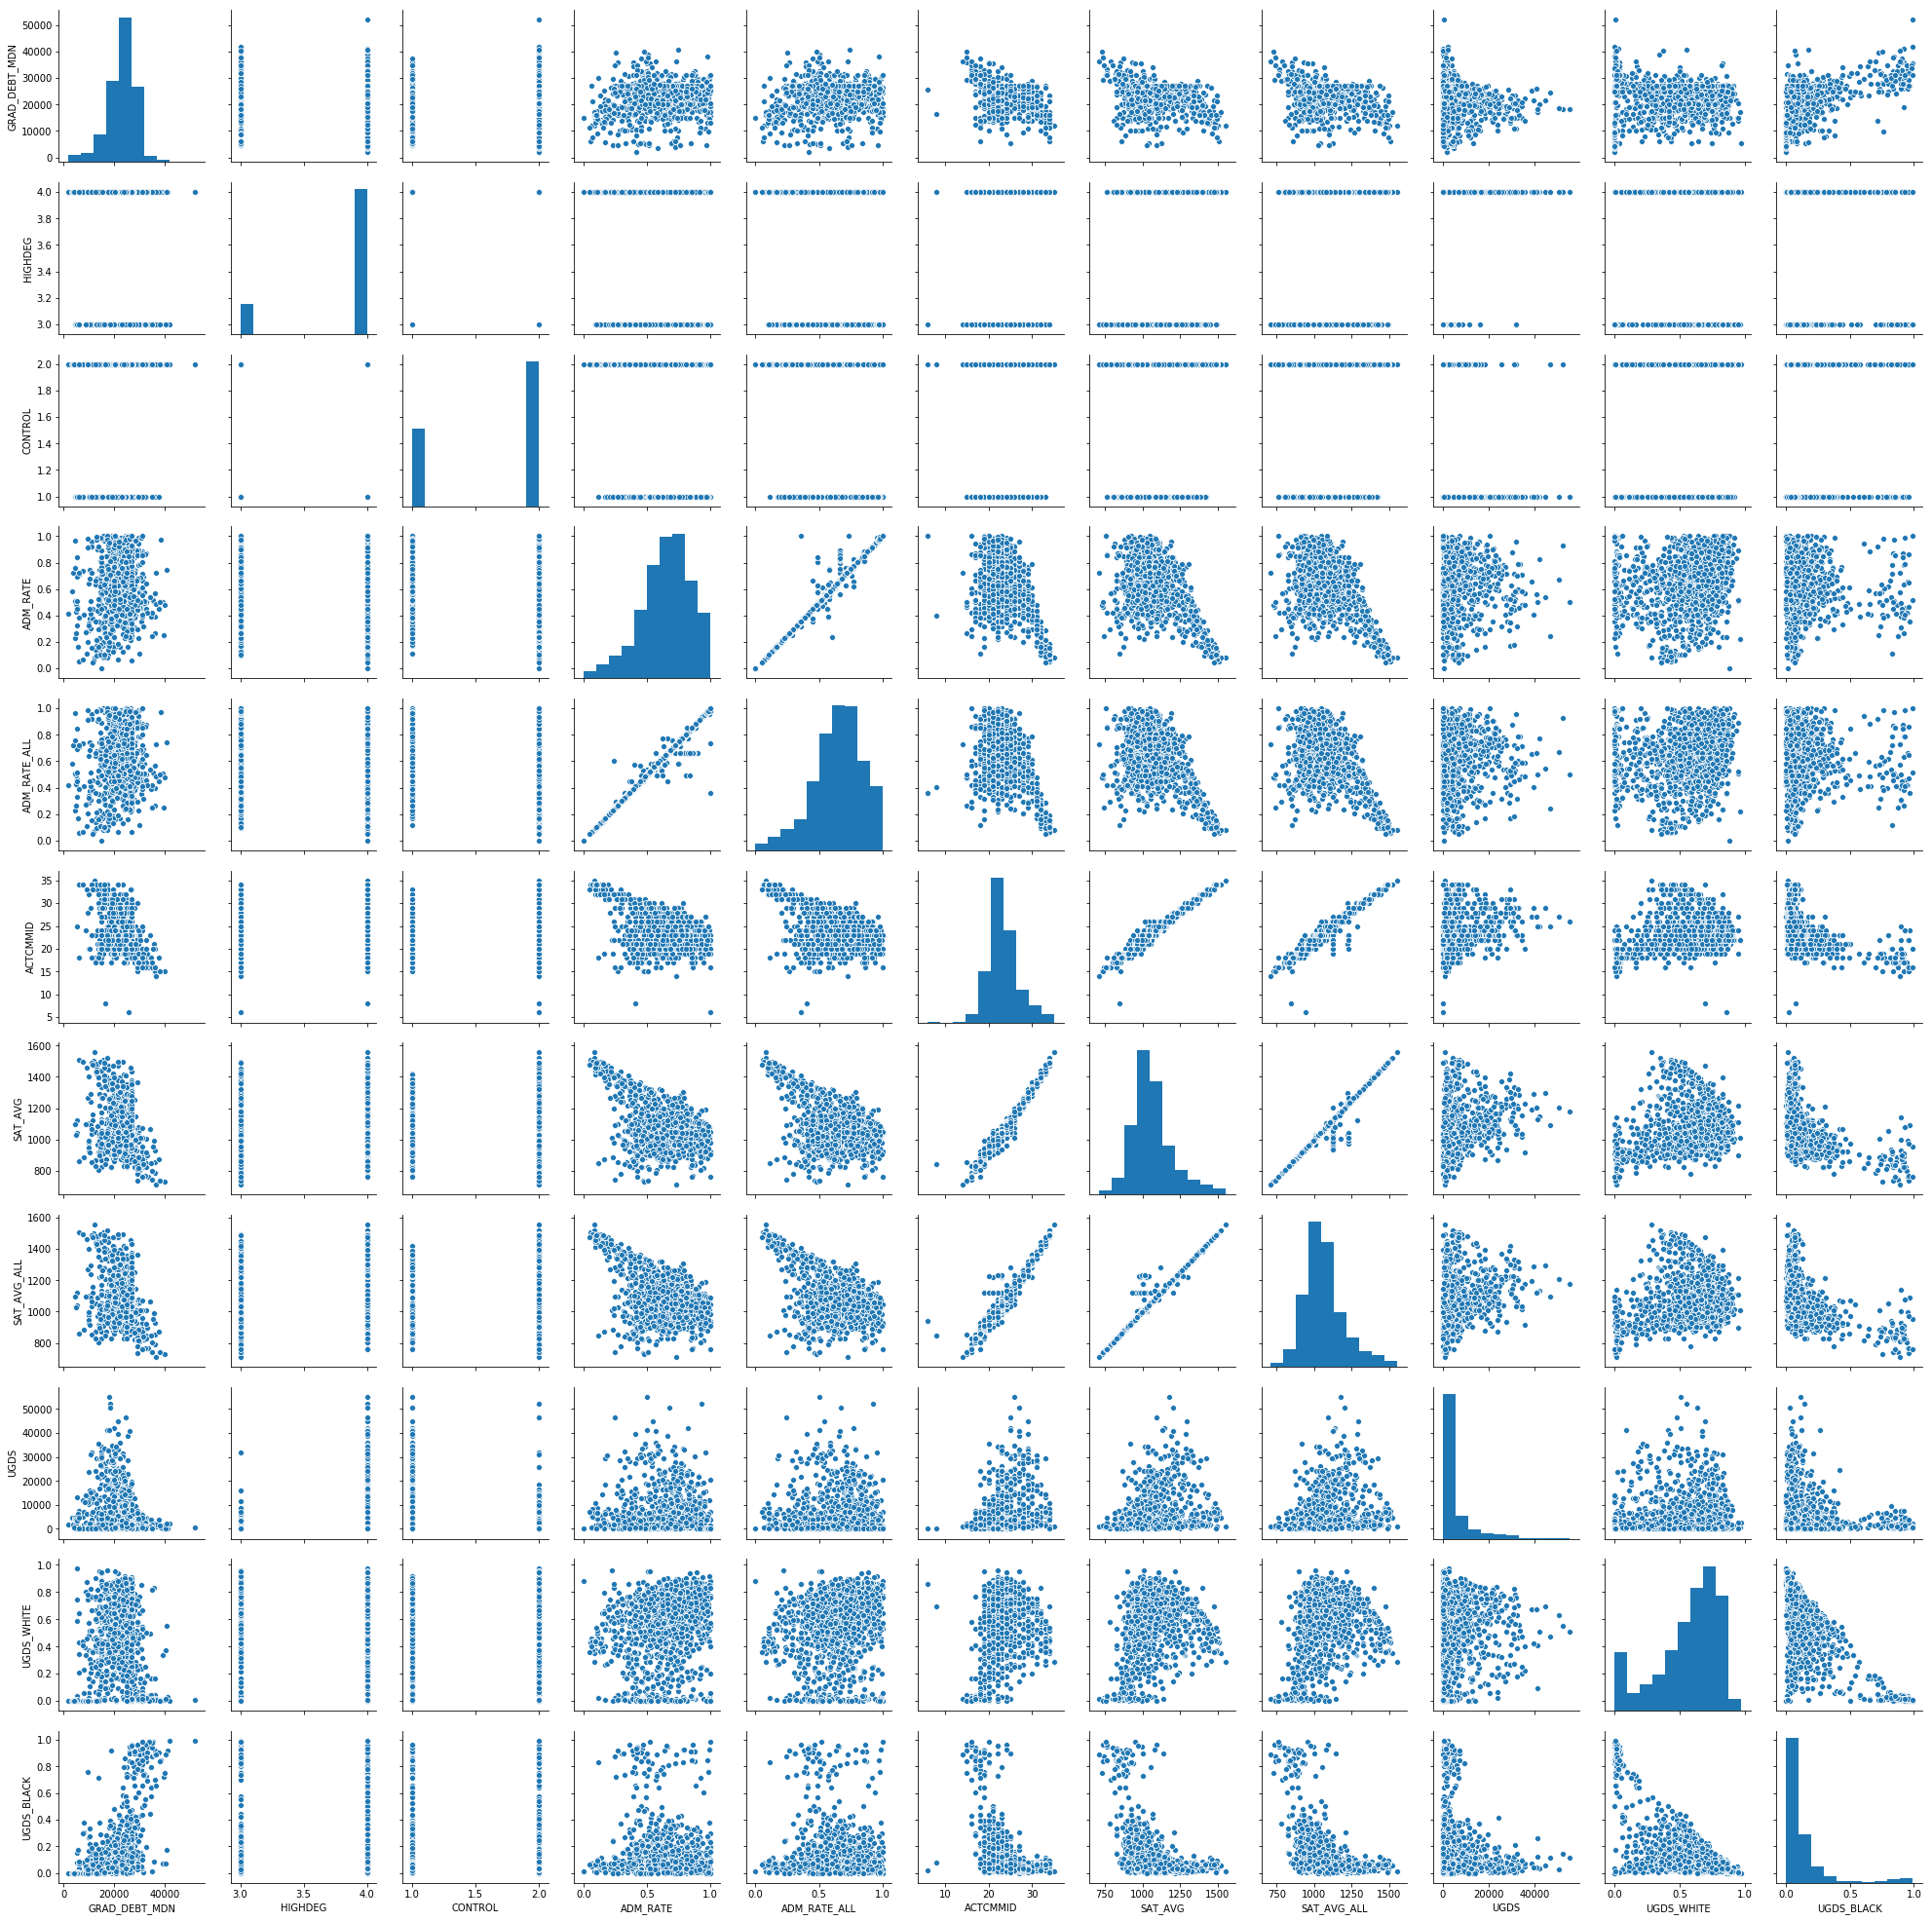

In [86]:
model = [ 'GRAD_DEBT_MDN'] + predictors[:10]
sns.pairplot(dataframe, vars=model)

In [89]:
# HIGHDEG = 3 offers bachelors degrees only
#         = 4 offers graduate degrees as well
# then let's make this column a more traditional 0/1 categorical flag
dataframe['BACH_ONLY'] = dataframe.eval('HIGHDEG == 3').astype(int)
dataframe.drop(columns='HIGHDEG', inplace=True)

idx = predictors.index('HIGHDEG')
predictors[idx] = 'BACH_ONLY'

In [90]:
cols = ['ADM_RATE', 'ADM_RATE_ALL']
reference(cols)

ADM_RATE
admissions float IPEDS
Admission rate
nan

ADM_RATE_ALL
admissions float IPEDS
Admission rate for all campuses rolled up to the 6-digit OPE ID
nan



In [91]:
print(dataframe[cols].count())

ADM_RATE        1489
ADM_RATE_ALL    1513
dtype: int64


In [93]:
# if the local branch admissions rate is not available,
# use the system admissions rate as a best guess
# then drop ADM_RATE_ALL as too collinear with ADM_RATE
dataframe.ADM_RATE = dataframe.ADM_RATE.fillna(value=dataframe.ADM_RATE_ALL)
dataframe.drop(columns='ADM_RATE_ALL', inplace=True)

pop_predictor('ADM_RATE_ALL')

In [94]:
# We can do a smilar thing with collinear colums
# SAT_AVG and SAT_AVG_ALL
dataframe.SAT_AVG = dataframe.SAT_AVG.fillna(value=dataframe.SAT_AVG_ALL)
dataframe.drop(columns='SAT_AVG_ALL', inplace=True)

pop_predictor('SAT_AVG_ALL')

In [96]:
cols = ['ACTCMMID', 'SAT_AVG']
dataframe.loc[:, cols].corr()

,ACTCMMID,SAT_AVG
ACTCMMID,1.000000,0.976843
SAT_AVG,0.976843,1.000000


In [97]:
# SAT and ACT scores are very collinear, both graphically and numerically

In [98]:
(dataframe.ACTCMMID.isnull() & dataframe.SAT_AVG.notnull()).sum()

44

In [99]:
(dataframe.ACTCMMID.notnull() & dataframe.SAT_AVG.isnull()).sum()

0

It looks like there is more SAT data than ACT data, so use SAT data for the predictor

In [100]:
pop_predictor('ACTCMMID')


In [101]:
# then let's make this column a more traditional 0/1 categorical flag
dataframe['PUBLIC'] = dataframe.eval('CONTROL == 1').astype(int)
dataframe['PRIVATE'] = dataframe.eval('CONTROL == 2').astype(int)
dataframe.drop(columns='CONTROL', inplace=True)

idx = predictors.index('CONTROL')
predictors[idx] = 'PUBLIC'
predictors = predictors + ['PRIVATE']

In [102]:
predictors

['BACH_ONLY',
 'PUBLIC',
 'ADM_RATE',
 'SAT_AVG',
 'UGDS',
 'UGDS_WHITE',
 'UGDS_BLACK',
 'UGDS_HISP',
 'UGDS_ASIAN',
 'UGDS_AIAN',
 'UGDS_NHPI',
 'UGDS_2MOR',
 'UGDS_NRA',
 'UGDS_UNKN',
 'PPTUG_EF',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'TUITIONFEE_OUT',
 'TUITFTE',
 'INEXPFTE',
 'AVGFACSAL',
 'PFTFAC',
 'PCTPELL',
 'PFTFTUG1_EF',
 'PRIVATE']

## Next 10 columns 

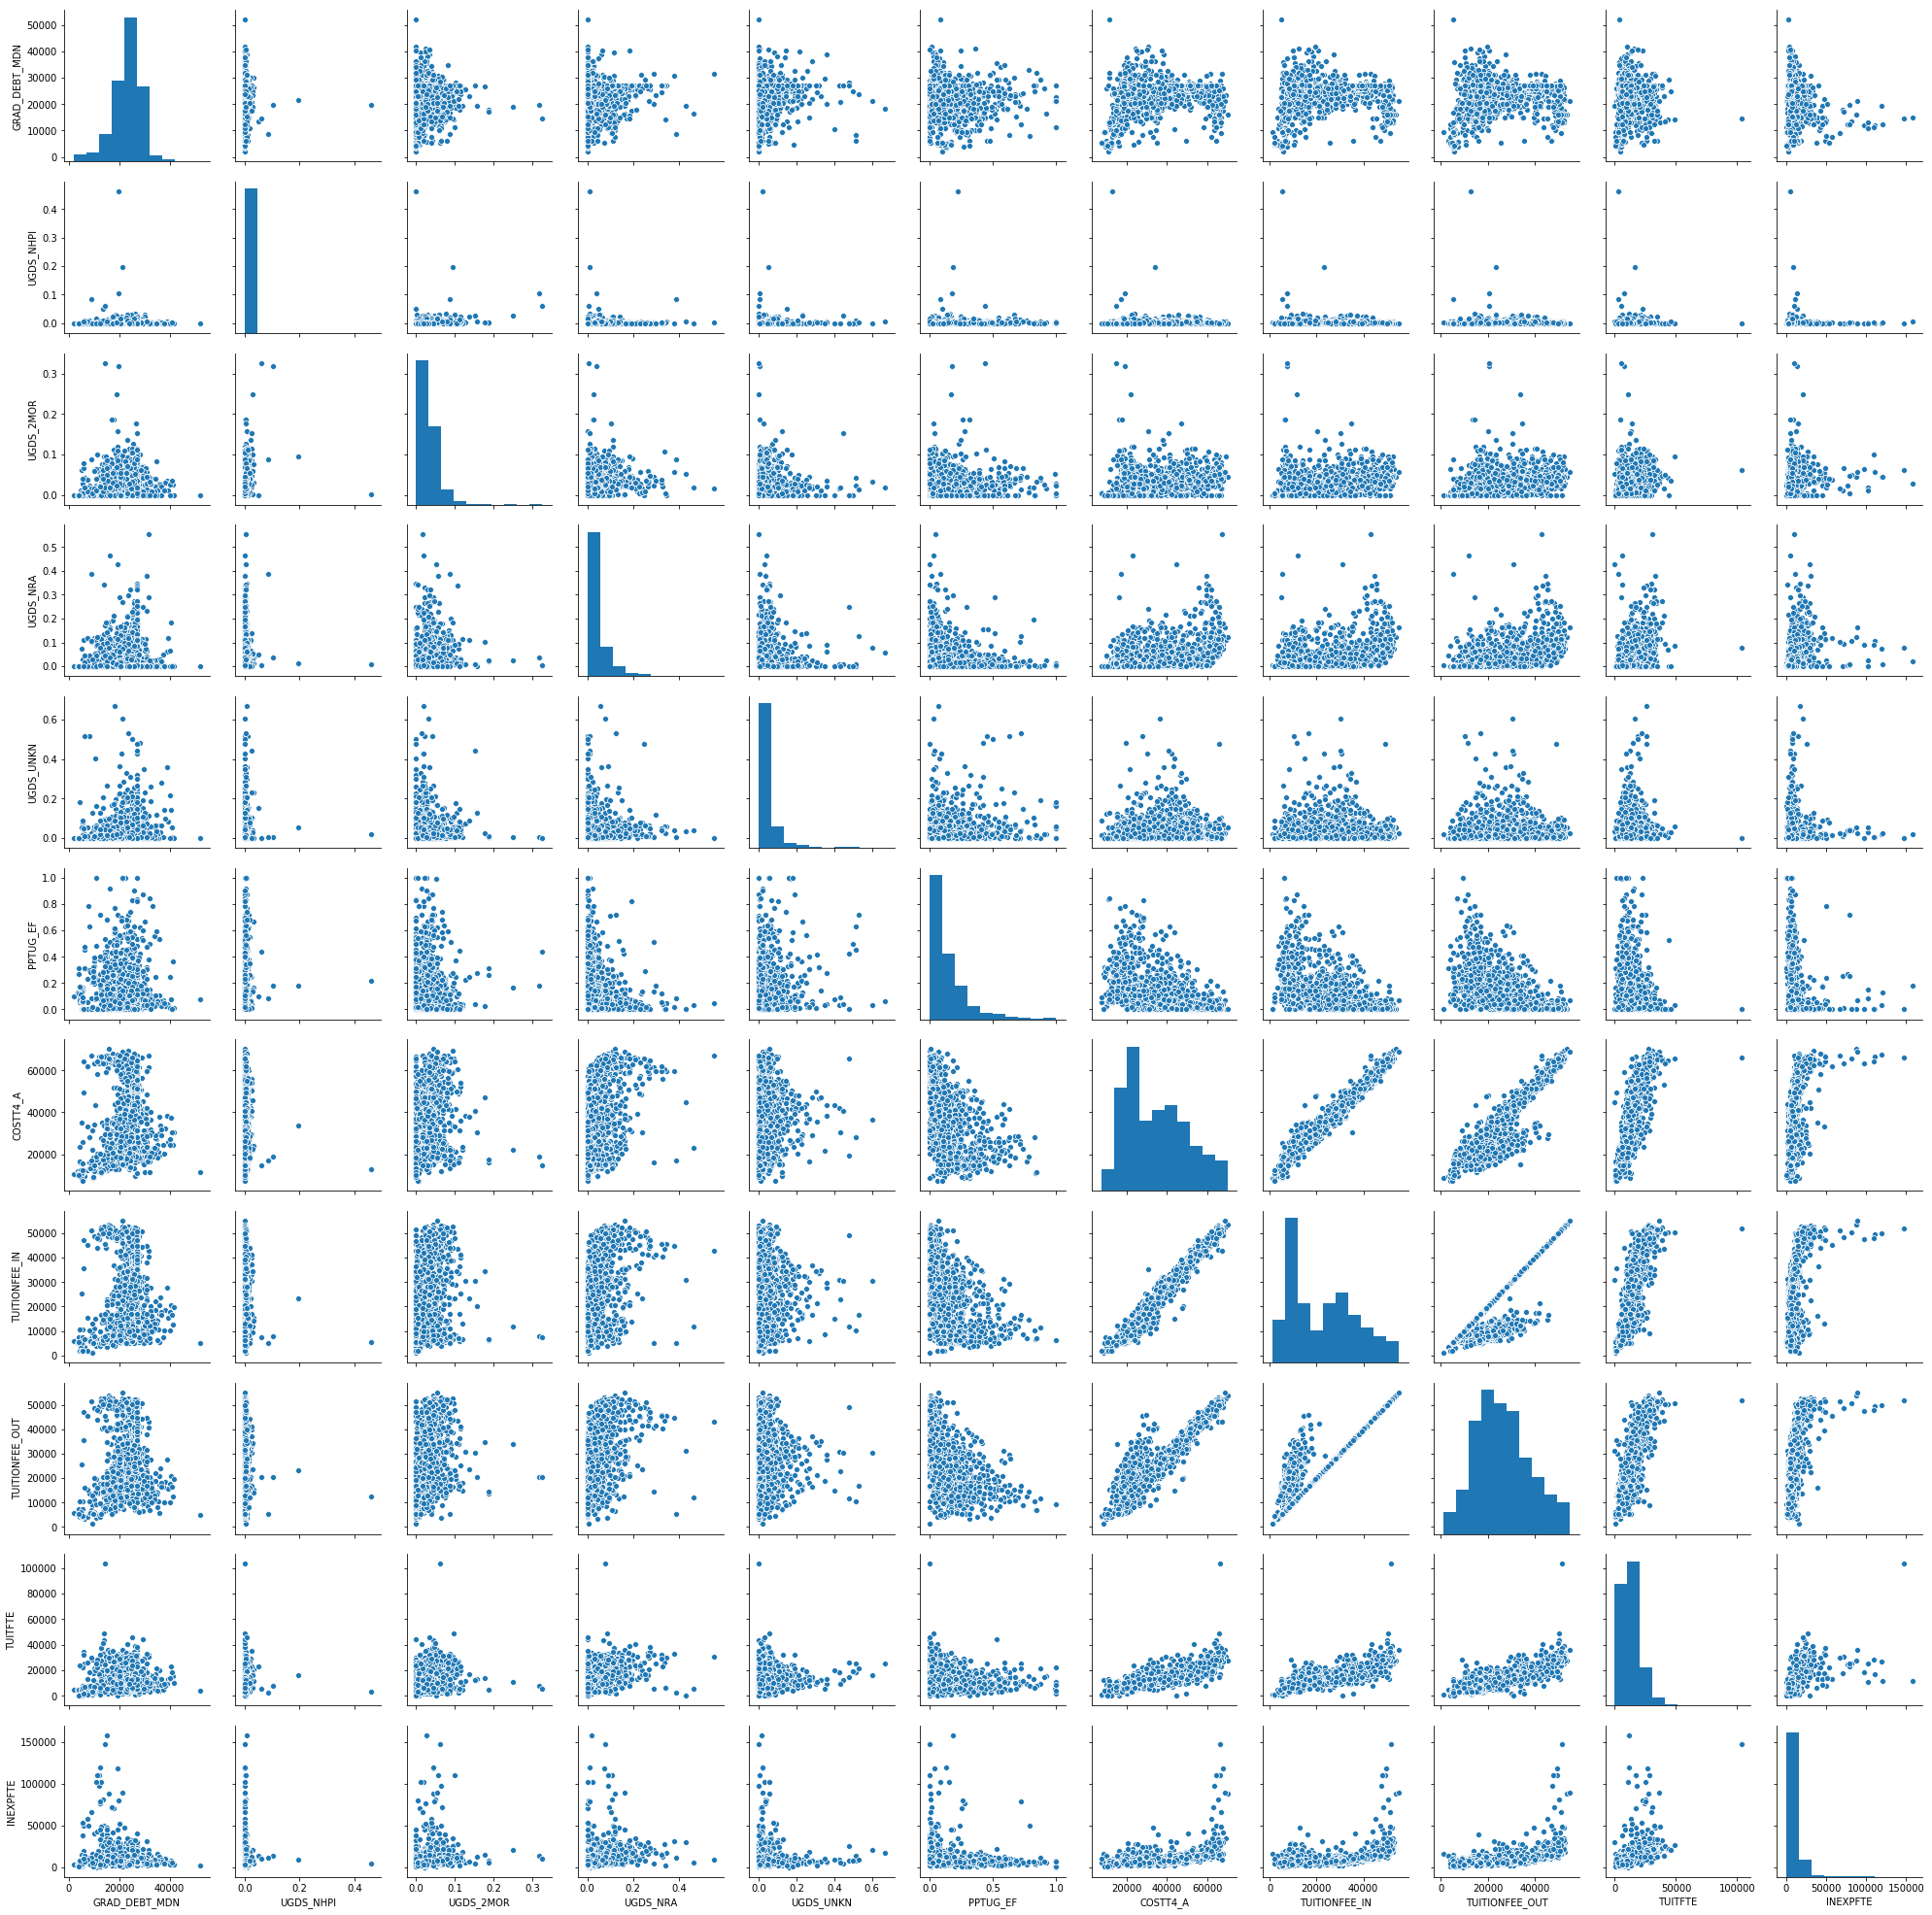

In [103]:
model = [ 'GRAD_DEBT_MDN'] + predictors[10:20]
sns.pairplot(dataframe, vars=model)

In [107]:
# In state and out of state tuition are highly collinear
# Assume most public universities enroll mostly in state students
# and use that as my typical tuition for now

# Tuition/fees in-state, tution/fees out-of-state, tuition revenue per full time equivalent
# and cost of attendance for those receiving title IV aid are highly correlated
dataframe[['TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITFTE', 'COSTT4_A']].corr()

,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,COSTT4_A
TUITIONFEE_IN,1.000000,0.898143,0.803566,0.981821
TUITIONFEE_OUT,0.898143,1.000000,0.777587,0.908267
TUITFTE,0.803566,0.777587,1.000000,0.818974
COSTT4_A,0.981821,0.908267,0.818974,1.000000


In [108]:
dataframe.TUITIONFEE_IN.count()

1614

In [109]:
dataframe.TUITIONFEE_OUT.count()

1614

In [110]:
dataframe.TUITFTE.count() 

1679

In [111]:
dataframe.COSTT4_A.count() 

1604

In [112]:
# I think if I don't know the school's tuition, I have to drop it
# there's just not enough info!
dataframe.dropna(axis=0, subset=['TUITIONFEE_OUT', 'TUITIONFEE_IN', 'COSTT4_A'], inplace=True)

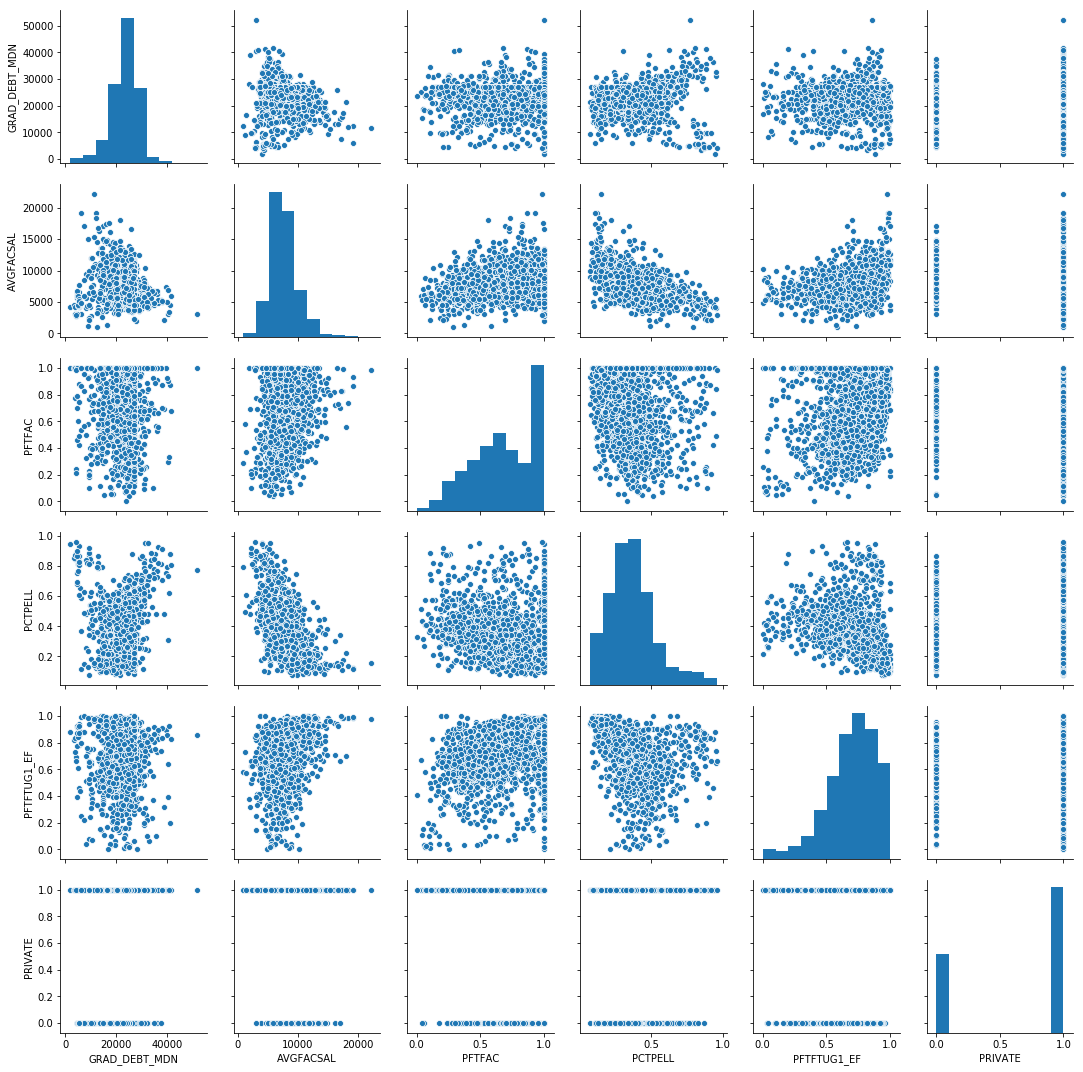

In [116]:
model = [ 'GRAD_DEBT_MDN'] + predictors[20:]
sns.pairplot(dataframe, vars=model) 

In [72]:
# And the OPENADMP flag should be changed to a traditional 0/1 categorical
# (It's currently 1 == yes, 2 = no)

In [117]:
# Final list of columns to choose are the target, predictors, plus
# the name, city, and state which I will need to eventually 
# join with the data scraped from collegedata.com

final_cols = ['GRAD_DEBT_MDN'] +  predictors +  save_labels

In [118]:
final_cols

['GRAD_DEBT_MDN',
 'BACH_ONLY',
 'PUBLIC',
 'ADM_RATE',
 'SAT_AVG',
 'UGDS',
 'UGDS_WHITE',
 'UGDS_BLACK',
 'UGDS_HISP',
 'UGDS_ASIAN',
 'UGDS_AIAN',
 'UGDS_NHPI',
 'UGDS_2MOR',
 'UGDS_NRA',
 'UGDS_UNKN',
 'PPTUG_EF',
 'COSTT4_A',
 'TUITIONFEE_IN',
 'TUITIONFEE_OUT',
 'TUITFTE',
 'INEXPFTE',
 'AVGFACSAL',
 'PFTFAC',
 'PCTPELL',
 'PFTFTUG1_EF',
 'PRIVATE',
 'INSTNM',
 'CITY',
 'STABBR']

In [77]:
filenames = [ filedir +  "MERGED20" + str(i) + "_" + str(i+1) + "_select.pck" for i in range(13,17) ]

for name,data in zip(filenames,dataframes ):
    data.loc[:, final_cols].to_pickle(name)

In [78]:
[ d.shape for d in dataframes ]

[(1603, 171), (1607, 171), (1606, 171), (1604, 171)]